In [1]:
import Pkg
Pkg.add("Turing")
Pkg.add("DifferentialEquations")
Pkg.add("Distributions")
Pkg.add("StatsPlots")
Pkg.add("Plots")
Pkg.add("ReverseDiff")
Pkg.add("Memoization")


    Updating registry at `~/.julia/registries/General.toml`


   Resolving package versions...


  No Changes to `~/Documents/programming/Ornstein-Uhlenbeck-AddedNoise/Project.toml`
  No Changes to `~/Documents/programming/Ornstein-Uhlenbeck-AddedNoise/Manifest.toml`


   Resolving package versions...


  No Changes to `~/Documents/programming/Ornstein-Uhlenbeck-AddedNoise/Project.toml`
  No Changes to `~/Documents/programming/Ornstein-Uhlenbeck-AddedNoise/Manifest.toml`


   Resolving package versions...


  No Changes to `~/Documents/programming/Ornstein-Uhlenbeck-AddedNoise/Project.toml`
  No Changes to `~/Documents/programming/Ornstein-Uhlenbeck-AddedNoise/Manifest.toml`


   Resolving package versions...


  No Changes to `~/Documents/programming/Ornstein-Uhlenbeck-AddedNoise/Project.toml`
  No Changes to `~/Documents/programming/Ornstein-Uhlenbeck-AddedNoise/Manifest.toml`


   Resolving package versions...


  No Changes to `~/Documents/programming/Ornstein-Uhlenbeck-AddedNoise/Project.toml`
  No Changes to `~/Documents/programming/Ornstein-Uhlenbeck-AddedNoise/Manifest.toml`


   Resolving package versions...


  No Changes to `~/Documents/programming/Ornstein-Uhlenbeck-AddedNoise/Project.toml`
  No Changes to `~/Documents/programming/Ornstein-Uhlenbeck-AddedNoise/Manifest.toml`


   Resolving package versions...


  No Changes to `~/Documents/programming/Ornstein-Uhlenbeck-AddedNoise/Project.toml`
  No Changes to `~/Documents/programming/Ornstein-Uhlenbeck-AddedNoise/Manifest.toml`


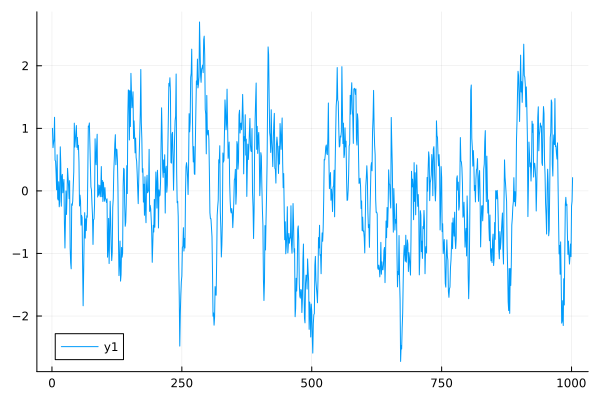

In [2]:
using DifferentialEquations
using Plots

μ = 0.0
σ = sqrt(2)
Θ = 1.0
W = OrnsteinUhlenbeckProcess(Θ,μ,σ,0.0,1.0)
prob = NoiseProblem(W,(0.0,100.0))
sol = solve(prob;dt=0.1)
plot(sol.u)

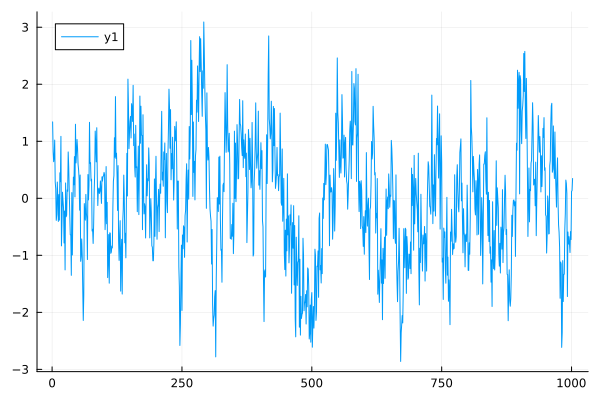

In [3]:
using Distributions, Random
ou_data = sol.u
noise = rand(Normal(0,0.4), length(ou_data))
plot(ou_data.+noise)

In [4]:
using Turing, ReverseDiff, Memoization
Turing.setadbackend(:reversediff)
Turing.setrdcache(true)
using Distributions
using LinearAlgebra

# Ornstein-Uhlenbeck process
@model ou(rn,T,delta_t) = begin
    ampl ~ Uniform(0.0,5.0)
    tau ~ Uniform(0.0,5.0)
    
    b = exp(-delta_t/tau)
    
    rn[1] ~ Normal(0,sqrt(ampl))
    
    for i=2:T
        rn[i] ~ Normal(rn[i-1]*b,sqrt(ampl*(1-b^2)))
    end
end

# Ornstein-Uhlenbeck process with added Gaussian noise
@model oupn(rn,T,delta_t,::Type{R}=Vector{Float64}) where {R} = begin
    ampl ~ Uniform(0.0,5.0)
    tau ~ Uniform(0.0,5.0)
    noise_ampl ~ Uniform(0.0,1)
    
    b = exp(-delta_t/tau)
    r = R(undef, T)
    
    r[1] ~ Normal(0,sqrt(ampl))
    
    for i=2:T
        r[i] ~ Normal(r[i-1]*b,sqrt(ampl*(1-b^2)))
    end
    rn ~ MvNormal(r,sqrt(noise_ampl))
end

oupn (generic function with 3 methods)

In [6]:
using StatsPlots
using BenchmarkTools
@time chnou = sample(ou(ou_data,length(ou_data),0.1), NUTS(0.65), 1000)
# Summarise results (currently requires the master branch from MCMCChains)
describe(chnou)


Sampling   0%|                                          |  ETA: N/A


┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference /Users/hstrey/.julia/packages/Turing/Suzsv/src/inference/hmc.jl:190
Sampling   0%|▎                                         |  ETA: 0:00:31
Sampling   1%|▍                                         |  ETA: 0:00:22


Sampling   1%|▋                                         |  ETA: 0:00:17
Sampling   2%|▊                                         |  ETA: 0:00:16
Sampling   2%|█                                         |  ETA: 0:00:14


Sampling   3%|█▏                                        |  ETA: 0:00:13
Sampling   3%|█▍                                        |  ETA: 0:00:12
Sampling   4%|█▋                                        |  ETA: 0:00:12


Sampling   4%|█▊                                        |  ETA: 0:00:11
Sampling   5%|██                                        |  ETA: 0:00:11
Sampling   5%|██▏                                       |  ETA: 0:00:10
Sampling   6%|██▍                                       |  ETA: 0:00:10


Sampling   6%|██▌                                       |  ETA: 0:00:10
Sampling   7%|██▊                                       |  ETA: 0:00:10
Sampling   7%|███                                       |  ETA: 0:00:10


Sampling   7%|███▏                                      |  ETA: 0:00:11
Sampling   8%|███▍                                      |  ETA: 0:00:11


Sampling   8%|███▌                                      |  ETA: 0:00:11
Sampling   9%|███▊                                      |  ETA: 0:00:10
Sampling   9%|███▉                                      |  ETA: 0:00:10


Sampling  10%|████▏                                     |  ETA: 0:00:10
Sampling  10%|████▎                                     |  ETA: 0:00:10
Sampling  11%|████▌                                     |  ETA: 0:00:10


Sampling  11%|████▊                                     |  ETA: 0:00:10
Sampling  12%|████▉                                     |  ETA: 0:00:10
Sampling  12%|█████▏                                    |  ETA: 0:00:10


Sampling  13%|█████▎                                    |  ETA: 0:00:10
Sampling  13%|█████▌                                    |  ETA: 0:00:10
Sampling  14%|█████▋                                    |  ETA: 0:00:09


Sampling  14%|█████▉                                    |  ETA: 0:00:09
Sampling  14%|██████▏                                   |  ETA: 0:00:09
Sampling  15%|██████▎                                   |  ETA: 0:00:09


Sampling  15%|██████▌                                   |  ETA: 0:00:09
Sampling  16%|██████▋                                   |  ETA: 0:00:09
Sampling  16%|██████▉                                   |  ETA: 0:00:09


Sampling  17%|███████                                   |  ETA: 0:00:09
Sampling  17%|███████▎                                  |  ETA: 0:00:09
Sampling  18%|███████▌                                  |  ETA: 0:00:09


Sampling  18%|███████▋                                  |  ETA: 0:00:09
Sampling  19%|███████▉                                  |  ETA: 0:00:09
Sampling  19%|████████                                  |  ETA: 0:00:09


Sampling  20%|████████▎                                 |  ETA: 0:00:08
Sampling  20%|████████▍                                 |  ETA: 0:00:08
Sampling  21%|████████▋                                 |  ETA: 0:00:08


Sampling  21%|████████▉                                 |  ETA: 0:00:08
Sampling  21%|█████████                                 |  ETA: 0:00:08


Sampling  22%|█████████▎                                |  ETA: 0:00:08
Sampling  22%|█████████▍                                |  ETA: 0:00:08
Sampling  23%|█████████▋                                |  ETA: 0:00:08


Sampling  23%|█████████▊                                |  ETA: 0:00:08
Sampling  24%|██████████                                |  ETA: 0:00:08
Sampling  24%|██████████▎                               |  ETA: 0:00:08


Sampling  25%|██████████▍                               |  ETA: 0:00:08
Sampling  25%|██████████▋                               |  ETA: 0:00:08
Sampling  26%|██████████▊                               |  ETA: 0:00:08


Sampling  26%|███████████                               |  ETA: 0:00:08
Sampling  27%|███████████▏                              |  ETA: 0:00:07
Sampling  27%|███████████▍                              |  ETA: 0:00:07
Sampling  28%|███████████▋                              |  ETA: 0:00:07


Sampling  28%|███████████▊                              |  ETA: 0:00:07
Sampling  28%|████████████                              |  ETA: 0:00:07
Sampling  29%|████████████▏                             |  ETA: 0:00:07
Sampling  29%|████████████▍                             |  ETA: 0:00:07


Sampling  30%|████████████▌                             |  ETA: 0:00:07
Sampling  30%|████████████▊                             |  ETA: 0:00:07
Sampling  31%|████████████▉                             |  ETA: 0:00:07


Sampling  31%|█████████████▏                            |  ETA: 0:00:07
Sampling  32%|█████████████▍                            |  ETA: 0:00:07


Sampling  32%|█████████████▌                            |  ETA: 0:00:07
Sampling  33%|█████████████▊                            |  ETA: 0:00:07
Sampling  33%|█████████████▉                            |  ETA: 0:00:07


Sampling  34%|██████████████▏                           |  ETA: 0:00:07
Sampling  34%|██████████████▎                           |  ETA: 0:00:06
Sampling  35%|██████████████▌                           |  ETA: 0:00:06


Sampling  35%|██████████████▊                           |  ETA: 0:00:06
Sampling  35%|██████████████▉                           |  ETA: 0:00:06
Sampling  36%|███████████████▏                          |  ETA: 0:00:06


Sampling  36%|███████████████▎                          |  ETA: 0:00:06
Sampling  37%|███████████████▌                          |  ETA: 0:00:06
Sampling  37%|███████████████▋                          |  ETA: 0:00:06


Sampling  38%|███████████████▉                          |  ETA: 0:00:06
Sampling  38%|████████████████▏                         |  ETA: 0:00:06
Sampling  39%|████████████████▎                         |  ETA: 0:00:06


Sampling  39%|████████████████▌                         |  ETA: 0:00:06
Sampling  40%|████████████████▋                         |  ETA: 0:00:06
Sampling  40%|████████████████▉                         |  ETA: 0:00:06


Sampling  41%|█████████████████                         |  ETA: 0:00:06
Sampling  41%|█████████████████▎                        |  ETA: 0:00:06


Sampling  42%|█████████████████▌                        |  ETA: 0:00:06
Sampling  42%|█████████████████▋                        |  ETA: 0:00:06
Sampling  42%|█████████████████▉                        |  ETA: 0:00:06


Sampling  43%|██████████████████                        |  ETA: 0:00:06
Sampling  43%|██████████████████▎                       |  ETA: 0:00:06
Sampling  44%|██████████████████▍                       |  ETA: 0:00:06


Sampling  44%|██████████████████▋                       |  ETA: 0:00:05
Sampling  45%|██████████████████▉                       |  ETA: 0:00:05


Sampling  45%|███████████████████                       |  ETA: 0:00:05
Sampling  46%|███████████████████▎                      |  ETA: 0:00:05
Sampling  46%|███████████████████▍                      |  ETA: 0:00:05


Sampling  47%|███████████████████▋                      |  ETA: 0:00:05
Sampling  47%|███████████████████▊                      |  ETA: 0:00:05
Sampling  48%|████████████████████                      |  ETA: 0:00:05


Sampling  48%|████████████████████▎                     |  ETA: 0:00:05
Sampling  49%|████████████████████▍                     |  ETA: 0:00:05
Sampling  49%|████████████████████▋                     |  ETA: 0:00:05


Sampling  49%|████████████████████▊                     |  ETA: 0:00:05
Sampling  50%|█████████████████████                     |  ETA: 0:00:05
Sampling  50%|█████████████████████▏                    |  ETA: 0:00:05


Sampling  51%|█████████████████████▍                    |  ETA: 0:00:05
Sampling  51%|█████████████████████▌                    |  ETA: 0:00:05
Sampling  52%|█████████████████████▊                    |  ETA: 0:00:05


Sampling  52%|██████████████████████                    |  ETA: 0:00:05
Sampling  53%|██████████████████████▏                   |  ETA: 0:00:05
Sampling  53%|██████████████████████▍                   |  ETA: 0:00:05


Sampling  54%|██████████████████████▌                   |  ETA: 0:00:05
Sampling  54%|██████████████████████▊                   |  ETA: 0:00:05
Sampling  55%|██████████████████████▉                   |  ETA: 0:00:04


Sampling  55%|███████████████████████▏                  |  ETA: 0:00:04
Sampling  56%|███████████████████████▍                  |  ETA: 0:00:04
Sampling  56%|███████████████████████▌                  |  ETA: 0:00:04


Sampling  56%|███████████████████████▊                  |  ETA: 0:00:04
Sampling  57%|███████████████████████▉                  |  ETA: 0:00:04


Sampling  57%|████████████████████████▏                 |  ETA: 0:00:04
Sampling  58%|████████████████████████▎                 |  ETA: 0:00:04
Sampling  58%|████████████████████████▌                 |  ETA: 0:00:04


Sampling  59%|████████████████████████▊                 |  ETA: 0:00:04
Sampling  59%|████████████████████████▉                 |  ETA: 0:00:04
Sampling  60%|█████████████████████████▏                |  ETA: 0:00:04


Sampling  60%|█████████████████████████▎                |  ETA: 0:00:04
Sampling  61%|█████████████████████████▌                |  ETA: 0:00:04
Sampling  61%|█████████████████████████▋                |  ETA: 0:00:04
Sampling  62%|█████████████████████████▉                |  ETA: 0:00:04


Sampling  62%|██████████████████████████▏               |  ETA: 0:00:04
Sampling  63%|██████████████████████████▎               |  ETA: 0:00:04
Sampling  63%|██████████████████████████▌               |  ETA: 0:00:04


Sampling  63%|██████████████████████████▋               |  ETA: 0:00:04
Sampling  64%|██████████████████████████▉               |  ETA: 0:00:04


Sampling  64%|███████████████████████████               |  ETA: 0:00:03
Sampling  65%|███████████████████████████▎              |  ETA: 0:00:03


Sampling  65%|███████████████████████████▌              |  ETA: 0:00:03
Sampling  66%|███████████████████████████▋              |  ETA: 0:00:03


Sampling  66%|███████████████████████████▉              |  ETA: 0:00:03
Sampling  67%|████████████████████████████              |  ETA: 0:00:03
Sampling  67%|████████████████████████████▎             |  ETA: 0:00:03


Sampling  68%|████████████████████████████▍             |  ETA: 0:00:03
Sampling  68%|████████████████████████████▋             |  ETA: 0:00:03
Sampling  69%|████████████████████████████▊             |  ETA: 0:00:03


Sampling  69%|█████████████████████████████             |  ETA: 0:00:03
Sampling  70%|█████████████████████████████▎            |  ETA: 0:00:03
Sampling  70%|█████████████████████████████▍            |  ETA: 0:00:03


Sampling  70%|█████████████████████████████▋            |  ETA: 0:00:03
Sampling  71%|█████████████████████████████▊            |  ETA: 0:00:03
Sampling  71%|██████████████████████████████            |  ETA: 0:00:03


Sampling  72%|██████████████████████████████▏           |  ETA: 0:00:03
Sampling  72%|██████████████████████████████▍           |  ETA: 0:00:03
Sampling  73%|██████████████████████████████▋           |  ETA: 0:00:03


Sampling  73%|██████████████████████████████▊           |  ETA: 0:00:03
Sampling  74%|███████████████████████████████           |  ETA: 0:00:03


Sampling  74%|███████████████████████████████▏          |  ETA: 0:00:03
Sampling  75%|███████████████████████████████▍          |  ETA: 0:00:03


Sampling  75%|███████████████████████████████▌          |  ETA: 0:00:02
Sampling  76%|███████████████████████████████▊          |  ETA: 0:00:02
Sampling  76%|████████████████████████████████          |  ETA: 0:00:02


Sampling  77%|████████████████████████████████▏         |  ETA: 0:00:02
Sampling  77%|████████████████████████████████▍         |  ETA: 0:00:02
Sampling  77%|████████████████████████████████▌         |  ETA: 0:00:02


Sampling  78%|████████████████████████████████▊         |  ETA: 0:00:02
Sampling  78%|████████████████████████████████▉         |  ETA: 0:00:02
Sampling  79%|█████████████████████████████████▏        |  ETA: 0:00:02


Sampling  79%|█████████████████████████████████▍        |  ETA: 0:00:02
Sampling  80%|█████████████████████████████████▌        |  ETA: 0:00:02


Sampling  80%|█████████████████████████████████▊        |  ETA: 0:00:02
Sampling  81%|█████████████████████████████████▉        |  ETA: 0:00:02
Sampling  81%|██████████████████████████████████▏       |  ETA: 0:00:02


Sampling  82%|██████████████████████████████████▎       |  ETA: 0:00:02
Sampling  82%|██████████████████████████████████▌       |  ETA: 0:00:02


Sampling  83%|██████████████████████████████████▊       |  ETA: 0:00:02
Sampling  83%|██████████████████████████████████▉       |  ETA: 0:00:02


Sampling  84%|███████████████████████████████████▏      |  ETA: 0:00:02
Sampling  84%|███████████████████████████████████▎      |  ETA: 0:00:02


Sampling  84%|███████████████████████████████████▌      |  ETA: 0:00:02
Sampling  85%|███████████████████████████████████▋      |  ETA: 0:00:02


Sampling  85%|███████████████████████████████████▉      |  ETA: 0:00:01
Sampling  86%|████████████████████████████████████▏     |  ETA: 0:00:01


Sampling  86%|████████████████████████████████████▎     |  ETA: 0:00:01
Sampling  87%|████████████████████████████████████▌     |  ETA: 0:00:01


Sampling  87%|████████████████████████████████████▋     |  ETA: 0:00:01
Sampling  88%|████████████████████████████████████▉     |  ETA: 0:00:01


Sampling  88%|█████████████████████████████████████     |  ETA: 0:00:01
Sampling  89%|█████████████████████████████████████▎    |  ETA: 0:00:01
Sampling  89%|█████████████████████████████████████▍    |  ETA: 0:00:01


Sampling  90%|█████████████████████████████████████▋    |  ETA: 0:00:01
Sampling  90%|█████████████████████████████████████▉    |  ETA: 0:00:01


Sampling  91%|██████████████████████████████████████    |  ETA: 0:00:01
Sampling  91%|██████████████████████████████████████▎   |  ETA: 0:00:01
Sampling  91%|██████████████████████████████████████▍   |  ETA: 0:00:01


Sampling  92%|██████████████████████████████████████▋   |  ETA: 0:00:01
Sampling  92%|██████████████████████████████████████▊   |  ETA: 0:00:01


Sampling  93%|███████████████████████████████████████   |  ETA: 0:00:01
Sampling  93%|███████████████████████████████████████▎  |  ETA: 0:00:01
Sampling  94%|███████████████████████████████████████▍  |  ETA: 0:00:01


Sampling  94%|███████████████████████████████████████▋  |  ETA: 0:00:01
Sampling  95%|███████████████████████████████████████▊  |  ETA: 0:00:01


Sampling  95%|████████████████████████████████████████  |  ETA: 0:00:00
Sampling  96%|████████████████████████████████████████▏ |  ETA: 0:00:00


Sampling  96%|████████████████████████████████████████▍ |  ETA: 0:00:00
Sampling  97%|████████████████████████████████████████▋ |  ETA: 0:00:00
Sampling  97%|████████████████████████████████████████▊ |  ETA: 0:00:00


Sampling  98%|█████████████████████████████████████████ |  ETA: 0:00:00
Sampling  98%|█████████████████████████████████████████▏|  ETA: 0:00:00


Sampling  98%|█████████████████████████████████████████▍|  ETA: 0:00:00
Sampling  99%|█████████████████████████████████████████▌|  ETA: 0:00:00
Sampling  99%|█████████████████████████████████████████▊|  ETA: 0:00:00

 10.167489 seconds (997.26 k allocations: 97.755 MiB, 0.23% gc time)



Sampling 100%|██████████████████████████████████████████|  ETA: 0:00:00
Sampling 100%|██████████████████████████████████████████| Time: 0:00:10


2-element Vector{ChainDataFrame}:
 Summary Statistics (2 x 8)
 Quantiles (2 x 6)

In [8]:
using StatsPlots
data = ou_data .+ noise
@time chnpn = sample(oupn(data,length(data),0.1), NUTS(0.65), 1000)
describe(chnpn)

Sampling   0%|                                          |  ETA: N/A


┌ Info: Found initial step size
│   ϵ = 0.025
└ @ Turing.Inference /Users/hstrey/.julia/packages/Turing/Suzsv/src/inference/hmc.jl:190
Sampling   0%|▎                                         |  ETA: 0:02:01


Sampling   1%|▍                                         |  ETA: 0:01:35


Sampling   1%|▋                                         |  ETA: 0:01:29


Sampling   2%|▊                                         |  ETA: 0:01:17


Sampling   2%|█                                         |  ETA: 0:01:07


Sampling   3%|█▏                                        |  ETA: 0:01:04


Sampling   3%|█▍                                        |  ETA: 0:01:04


Sampling   4%|█▋                                        |  ETA: 0:01:03


Sampling   4%|█▊                                        |  ETA: 0:01:00


Sampling   5%|██                                        |  ETA: 0:00:58


Sampling   5%|██▏                                       |  ETA: 0:00:56


Sampling   6%|██▍                                       |  ETA: 0:00:56


Sampling   6%|██▌                                       |  ETA: 0:00:54


Sampling   7%|██▊                                       |  ETA: 0:00:52


Sampling   7%|███                                       |  ETA: 0:00:52


Sampling   7%|███▏                                      |  ETA: 0:00:52


Sampling   8%|███▍                                      |  ETA: 0:00:51


Sampling   8%|███▌                                      |  ETA: 0:00:51


Sampling   9%|███▊                                      |  ETA: 0:00:50


Sampling   9%|███▉                                      |  ETA: 0:00:50


Sampling  10%|████▏                                     |  ETA: 0:00:49


Sampling  10%|████▎                                     |  ETA: 0:00:48


Sampling  11%|████▌                                     |  ETA: 0:00:47


Sampling  11%|████▊                                     |  ETA: 0:00:46


Sampling  12%|████▉                                     |  ETA: 0:00:46


Sampling  12%|█████▏                                    |  ETA: 0:00:46


Sampling  13%|█████▎                                    |  ETA: 0:00:45


Sampling  13%|█████▌                                    |  ETA: 0:00:45


Sampling  14%|█████▋                                    |  ETA: 0:00:44


Sampling  14%|█████▉                                    |  ETA: 0:00:43


Sampling  14%|██████▏                                   |  ETA: 0:00:42


Sampling  15%|██████▎                                   |  ETA: 0:00:42


Sampling  15%|██████▌                                   |  ETA: 0:00:41


Sampling  16%|██████▋                                   |  ETA: 0:00:41


Sampling  16%|██████▉                                   |  ETA: 0:00:40


Sampling  17%|███████                                   |  ETA: 0:00:40


Sampling  17%|███████▎                                  |  ETA: 0:00:39


Sampling  18%|███████▌                                  |  ETA: 0:00:39


Sampling  18%|███████▋                                  |  ETA: 0:00:39


Sampling  19%|███████▉                                  |  ETA: 0:00:38


Sampling  19%|████████                                  |  ETA: 0:00:38


Sampling  20%|████████▎                                 |  ETA: 0:00:38


Sampling  20%|████████▍                                 |  ETA: 0:00:38


Sampling  21%|████████▋                                 |  ETA: 0:00:37


Sampling  21%|████████▉                                 |  ETA: 0:00:37


Sampling  21%|█████████                                 |  ETA: 0:00:36


Sampling  22%|█████████▎                                |  ETA: 0:00:36


Sampling  22%|█████████▍                                |  ETA: 0:00:35


Sampling  23%|█████████▋                                |  ETA: 0:00:35


Sampling  23%|█████████▊                                |  ETA: 0:00:35


Sampling  24%|██████████                                |  ETA: 0:00:34


Sampling  24%|██████████▎                               |  ETA: 0:00:34


Sampling  25%|██████████▍                               |  ETA: 0:00:34


Sampling  25%|██████████▋                               |  ETA: 0:00:33


Sampling  26%|██████████▊                               |  ETA: 0:00:33


Sampling  26%|███████████                               |  ETA: 0:00:32


Sampling  27%|███████████▏                              |  ETA: 0:00:32


Sampling  27%|███████████▍                              |  ETA: 0:00:32


Sampling  28%|███████████▋                              |  ETA: 0:00:31


Sampling  28%|███████████▊                              |  ETA: 0:00:31


Sampling  28%|████████████                              |  ETA: 0:00:31


Sampling  29%|████████████▏                             |  ETA: 0:00:30


Sampling  29%|████████████▍                             |  ETA: 0:00:30


Sampling  30%|████████████▌                             |  ETA: 0:00:30


Sampling  30%|████████████▊                             |  ETA: 0:00:29


Sampling  31%|████████████▉                             |  ETA: 0:00:29


Sampling  31%|█████████████▏                            |  ETA: 0:00:29


Sampling  32%|█████████████▍                            |  ETA: 0:00:29


Sampling  32%|█████████████▌                            |  ETA: 0:00:28


Sampling  33%|█████████████▊                            |  ETA: 0:00:28


Sampling  33%|█████████████▉                            |  ETA: 0:00:28


Sampling  34%|██████████████▏                           |  ETA: 0:00:28


Sampling  34%|██████████████▎                           |  ETA: 0:00:28


Sampling  35%|██████████████▌                           |  ETA: 0:00:27


Sampling  35%|██████████████▊                           |  ETA: 0:00:27


Sampling  35%|██████████████▉                           |  ETA: 0:00:27


Sampling  36%|███████████████▏                          |  ETA: 0:00:27


Sampling  36%|███████████████▎                          |  ETA: 0:00:27


Sampling  37%|███████████████▌                          |  ETA: 0:00:27


Sampling  37%|███████████████▋                          |  ETA: 0:00:27


Sampling  38%|███████████████▉                          |  ETA: 0:00:26


Sampling  38%|████████████████▏                         |  ETA: 0:00:26


Sampling  39%|████████████████▎                         |  ETA: 0:00:26


Sampling  39%|████████████████▌                         |  ETA: 0:00:26


Sampling  40%|████████████████▋                         |  ETA: 0:00:26


Sampling  40%|████████████████▉                         |  ETA: 0:00:26


Sampling  41%|█████████████████                         |  ETA: 0:00:25


Sampling  41%|█████████████████▎                        |  ETA: 0:00:25


Sampling  42%|█████████████████▌                        |  ETA: 0:00:25


Sampling  42%|█████████████████▋                        |  ETA: 0:00:25


Sampling  42%|█████████████████▉                        |  ETA: 0:00:25


Sampling  43%|██████████████████                        |  ETA: 0:00:25


Sampling  43%|██████████████████▎                       |  ETA: 0:00:24


Sampling  44%|██████████████████▍                       |  ETA: 0:00:24


Sampling  44%|██████████████████▋                       |  ETA: 0:00:24


Sampling  45%|██████████████████▉                       |  ETA: 0:00:24


Sampling  45%|███████████████████                       |  ETA: 0:00:24


Sampling  46%|███████████████████▎                      |  ETA: 0:00:24


Sampling  46%|███████████████████▍                      |  ETA: 0:00:24


Sampling  47%|███████████████████▋                      |  ETA: 0:00:23


Sampling  47%|███████████████████▊                      |  ETA: 0:00:23


Sampling  48%|████████████████████                      |  ETA: 0:00:23


Sampling  48%|████████████████████▎                     |  ETA: 0:00:23


Sampling  49%|████████████████████▍                     |  ETA: 0:00:23


Sampling  49%|████████████████████▋                     |  ETA: 0:00:23


Sampling  49%|████████████████████▊                     |  ETA: 0:00:22


Sampling  50%|█████████████████████                     |  ETA: 0:00:22


Sampling  50%|█████████████████████▏                    |  ETA: 0:00:22


Sampling  51%|█████████████████████▍                    |  ETA: 0:00:22


Sampling  51%|█████████████████████▌                    |  ETA: 0:00:22


Sampling  52%|█████████████████████▊                    |  ETA: 0:00:21


Sampling  52%|██████████████████████                    |  ETA: 0:00:21


Sampling  53%|██████████████████████▏                   |  ETA: 0:00:21


Sampling  53%|██████████████████████▍                   |  ETA: 0:00:21


Sampling  54%|██████████████████████▌                   |  ETA: 0:00:21


Sampling  54%|██████████████████████▊                   |  ETA: 0:00:20


Sampling  55%|██████████████████████▉                   |  ETA: 0:00:20


Sampling  55%|███████████████████████▏                  |  ETA: 0:00:20


Sampling  56%|███████████████████████▍                  |  ETA: 0:00:20


Sampling  56%|███████████████████████▌                  |  ETA: 0:00:20


Sampling  56%|███████████████████████▊                  |  ETA: 0:00:20


Sampling  57%|███████████████████████▉                  |  ETA: 0:00:19


Sampling  57%|████████████████████████▏                 |  ETA: 0:00:19


Sampling  58%|████████████████████████▎                 |  ETA: 0:00:19


Sampling  58%|████████████████████████▌                 |  ETA: 0:00:19


Sampling  59%|████████████████████████▊                 |  ETA: 0:00:19


Sampling  59%|████████████████████████▉                 |  ETA: 0:00:18


Sampling  60%|█████████████████████████▏                |  ETA: 0:00:18


Sampling  60%|█████████████████████████▎                |  ETA: 0:00:18


Sampling  61%|█████████████████████████▌                |  ETA: 0:00:18


Sampling  61%|█████████████████████████▋                |  ETA: 0:00:18


Sampling  62%|█████████████████████████▉                |  ETA: 0:00:17


Sampling  62%|██████████████████████████▏               |  ETA: 0:00:17


Sampling  63%|██████████████████████████▎               |  ETA: 0:00:17


Sampling  63%|██████████████████████████▌               |  ETA: 0:00:17


Sampling  63%|██████████████████████████▋               |  ETA: 0:00:17


Sampling  64%|██████████████████████████▉               |  ETA: 0:00:16


Sampling  64%|███████████████████████████               |  ETA: 0:00:16


Sampling  65%|███████████████████████████▎              |  ETA: 0:00:16


Sampling  65%|███████████████████████████▌              |  ETA: 0:00:16


Sampling  66%|███████████████████████████▋              |  ETA: 0:00:16


Sampling  66%|███████████████████████████▉              |  ETA: 0:00:15


Sampling  67%|████████████████████████████              |  ETA: 0:00:15


Sampling  67%|████████████████████████████▎             |  ETA: 0:00:15


Sampling  68%|████████████████████████████▍             |  ETA: 0:00:15


Sampling  68%|████████████████████████████▋             |  ETA: 0:00:15


Sampling  69%|████████████████████████████▊             |  ETA: 0:00:14


Sampling  69%|█████████████████████████████             |  ETA: 0:00:14


Sampling  70%|█████████████████████████████▎            |  ETA: 0:00:14


Sampling  70%|█████████████████████████████▍            |  ETA: 0:00:14


Sampling  70%|█████████████████████████████▋            |  ETA: 0:00:14


Sampling  71%|█████████████████████████████▊            |  ETA: 0:00:13


Sampling  71%|██████████████████████████████            |  ETA: 0:00:13


Sampling  72%|██████████████████████████████▏           |  ETA: 0:00:13


Sampling  72%|██████████████████████████████▍           |  ETA: 0:00:13


Sampling  73%|██████████████████████████████▋           |  ETA: 0:00:12


Sampling  73%|██████████████████████████████▊           |  ETA: 0:00:12


Sampling  74%|███████████████████████████████           |  ETA: 0:00:12


Sampling  74%|███████████████████████████████▏          |  ETA: 0:00:12


Sampling  75%|███████████████████████████████▍          |  ETA: 0:00:12


Sampling  75%|███████████████████████████████▌          |  ETA: 0:00:11


Sampling  76%|███████████████████████████████▊          |  ETA: 0:00:11


Sampling  76%|████████████████████████████████          |  ETA: 0:00:11


Sampling  77%|████████████████████████████████▏         |  ETA: 0:00:11


Sampling  77%|████████████████████████████████▍         |  ETA: 0:00:11


Sampling  77%|████████████████████████████████▌         |  ETA: 0:00:10


Sampling  78%|████████████████████████████████▊         |  ETA: 0:00:10


Sampling  78%|████████████████████████████████▉         |  ETA: 0:00:10


Sampling  79%|█████████████████████████████████▏        |  ETA: 0:00:10


Sampling  79%|█████████████████████████████████▍        |  ETA: 0:00:10


Sampling  80%|█████████████████████████████████▌        |  ETA: 0:00:09


Sampling  80%|█████████████████████████████████▊        |  ETA: 0:00:09


Sampling  81%|█████████████████████████████████▉        |  ETA: 0:00:09


Sampling  81%|██████████████████████████████████▏       |  ETA: 0:00:09


Sampling  82%|██████████████████████████████████▎       |  ETA: 0:00:08


Sampling  82%|██████████████████████████████████▌       |  ETA: 0:00:08


Sampling  83%|██████████████████████████████████▊       |  ETA: 0:00:08


Sampling  83%|██████████████████████████████████▉       |  ETA: 0:00:08


Sampling  84%|███████████████████████████████████▏      |  ETA: 0:00:08


Sampling  84%|███████████████████████████████████▎      |  ETA: 0:00:07


Sampling  84%|███████████████████████████████████▌      |  ETA: 0:00:07


Sampling  85%|███████████████████████████████████▋      |  ETA: 0:00:07


Sampling  85%|███████████████████████████████████▉      |  ETA: 0:00:07


Sampling  86%|████████████████████████████████████▏     |  ETA: 0:00:07


Sampling  86%|████████████████████████████████████▎     |  ETA: 0:00:06


Sampling  87%|████████████████████████████████████▌     |  ETA: 0:00:06


Sampling  87%|████████████████████████████████████▋     |  ETA: 0:00:06


Sampling  88%|████████████████████████████████████▉     |  ETA: 0:00:06


Sampling  88%|█████████████████████████████████████     |  ETA: 0:00:05


Sampling  89%|█████████████████████████████████████▎    |  ETA: 0:00:05


Sampling  89%|█████████████████████████████████████▍    |  ETA: 0:00:05


Sampling  90%|█████████████████████████████████████▋    |  ETA: 0:00:05


Sampling  90%|█████████████████████████████████████▉    |  ETA: 0:00:05


Sampling  91%|██████████████████████████████████████    |  ETA: 0:00:04


Sampling  91%|██████████████████████████████████████▎   |  ETA: 0:00:04


Sampling  91%|██████████████████████████████████████▍   |  ETA: 0:00:04


Sampling  92%|██████████████████████████████████████▋   |  ETA: 0:00:04


Sampling  92%|██████████████████████████████████████▊   |  ETA: 0:00:04


Sampling  93%|███████████████████████████████████████   |  ETA: 0:00:03


Sampling  93%|███████████████████████████████████████▎  |  ETA: 0:00:03


Sampling  94%|███████████████████████████████████████▍  |  ETA: 0:00:03


Sampling  94%|███████████████████████████████████████▋  |  ETA: 0:00:03


Sampling  95%|███████████████████████████████████████▊  |  ETA: 0:00:02


Sampling  95%|████████████████████████████████████████  |  ETA: 0:00:02


Sampling  96%|████████████████████████████████████████▏ |  ETA: 0:00:02


Sampling  96%|████████████████████████████████████████▍ |  ETA: 0:00:02


Sampling  97%|████████████████████████████████████████▋ |  ETA: 0:00:02


Sampling  97%|████████████████████████████████████████▊ |  ETA: 0:00:01


Sampling  98%|█████████████████████████████████████████ |  ETA: 0:00:01


Sampling  98%|█████████████████████████████████████████▏|  ETA: 0:00:01


Sampling  98%|█████████████████████████████████████████▍|  ETA: 0:00:01


Sampling  99%|█████████████████████████████████████████▌|  ETA: 0:00:01


Sampling  99%|█████████████████████████████████████████▊|  ETA: 0:00:00


Sampling 100%|██████████████████████████████████████████|  ETA: 0:00:00


Sampling 100%|██████████████████████████████████████████| Time: 0:00:46


 48.654642 seconds (25.85 M allocations: 13.985 GiB, 1.64% gc time)


2-element Vector{ChainDataFrame}:
 Summary Statistics (1005 x 8)
 Quantiles (1005 x 6)

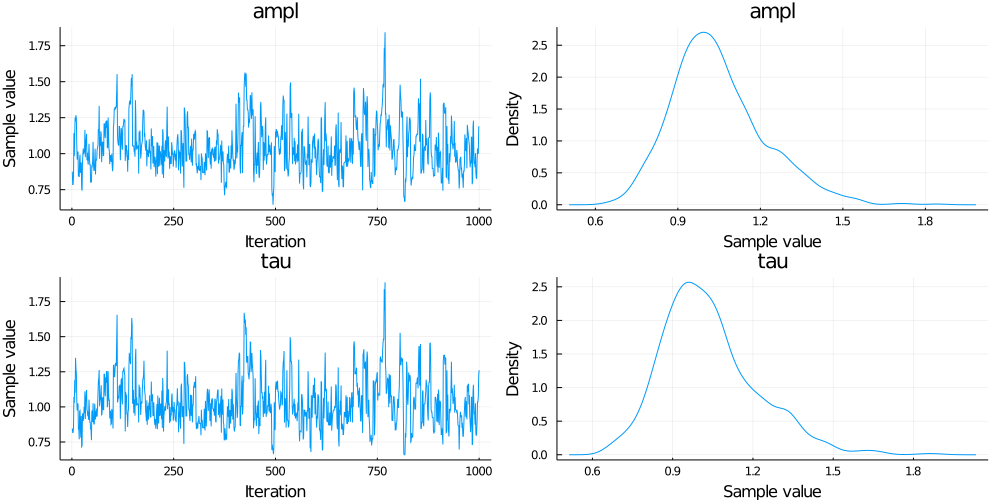

In [36]:
# Plot and save results
using Plots
p = plot(chn)

1.0917570184929886

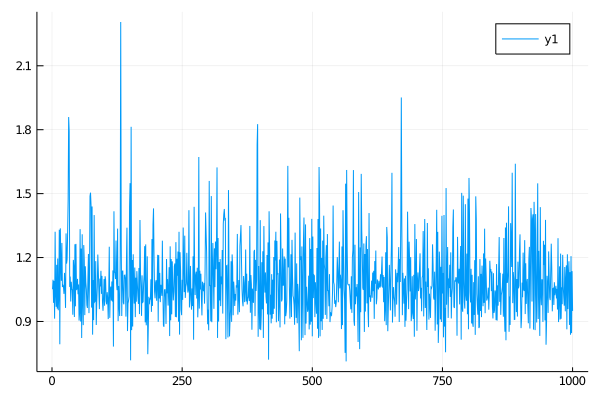

In [48]:
ampl_data = chnpn[:ampl].value.data
print(mean(ampl_data[:,1,1]))
plot(ampl_data[:,1,1])

In [49]:
r_data = chnpn[:r].value.data
r_mean=mean(r_data,dims=1)[1,:,1]

1002-element Array{Float64,1}:
  1.1729601975058386
  1.376086043053466
  0.8750202005445756
  0.41791978661624296
  0.24108458689083692
  0.380537925649892
  0.17911943958439142
  0.10496978489215396
 -0.05484711470881756
  0.13364849632845263
 -0.04042903456509873
  0.0502522888583229
  0.317246296078771
  ⋮
 -1.309830375127741
 -1.4805345848402143
 -2.3535667669233464
 -2.355610415376828
 -2.1287974461875634
 -1.298290085814181
 -1.5469271335326151
 -1.7323395349454402
 -1.6582589063945796
 -1.5444741378723734
 -1.7126201289240512
 -1.6612674031306733

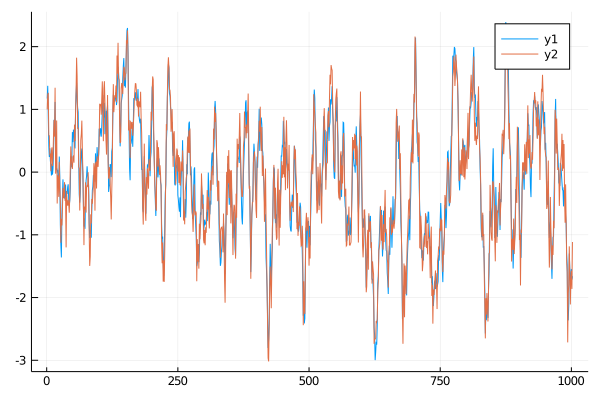

In [50]:
plot(r_mean)
plot!(sol.u)

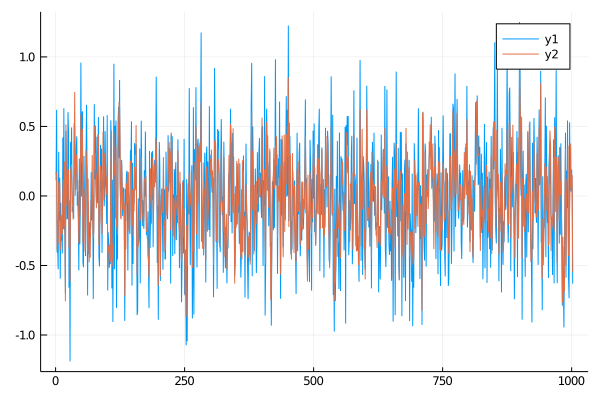

In [51]:
plot(noise)
plot!(r_mean.-sol.u)